In [1]:
import time 
t_script = time.time()

### Load libraries, functions, palette, theme

In [232]:
%run __libraries.ipynb

In [249]:
%run __functions.ipynb

### Load Saved Section if exists

In [4]:
dir_save = '02-Models-Evaluation'

## Models Evaluation

### Load Data

In [5]:
start_date = '2022-07-12'
end_date = '2022-10-15'

In [6]:
data = read_from_files(
    DIR_INPUT = './data-transformed/',
    BEGIN_DATE = start_date,
    END_DATE = end_date
)

In [7]:
data.shape

(931912, 23)

### Features Selection

In [8]:
features = [
    'tx_amount', 'tx_during_weekend', 'tx_during_night',
    'customer_id_nb_tx_1day_window', 'customer_id_avg_amount_1day_window',
    'customer_id_nb_tx_7day_window', 'customer_id_avg_amount_7day_window',
    'customer_id_nb_tx_30day_window', 'customer_id_avg_amount_30day_window',
    'terminal_id_nb_tx_1day_window', 'terminal_id_risk_1day_window',
    'terminal_id_nb_tx_7day_window', 'terminal_id_risk_7day_window',
    'terminal_id_nb_tx_30day_window', 'terminal_id_risk_30day_window'
]

target = 'tx_fraud'

In [9]:
len(features)

15

### Primary Parameters

In [10]:
%run __primary_parameters.ipynb

In [11]:
train_start, train_start_valid, train_start_test

(datetime.datetime(2022, 8, 25, 0, 0),
 datetime.datetime(2022, 8, 11, 0, 0),
 datetime.datetime(2022, 9, 15, 0, 0))

### Training and Evaluation Models

In [12]:
hyper_list = []

In [13]:
hyper_dict = {
    'Logistic Regression': {
        'penalty': None,
        'C': None,
        'solver': None,
        'max_iter': 5000,
        'random_state': seed
    },
    'Random Forest': {
        'n_estimators': None, 'max_depth': None,
        'random_state': seed
    },
    'XGBoost': {
        'n_estimators': None, 'max_depth': None, 
        'learning_rate': None, 'random_state': seed
    },
    'LightGBM': {
        'n_estimators': None, 'max_depth': None,
        'learning_rate': None, 'random_state': seed
    }
}

#### Logistic Regression

##### LR Baseline

In [14]:
clf_lr_base = LogisticRegression()

params_lr_base = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': [0.1, 1, 10],
    'estimator__solver': ['saga'],
    'estimator__max_iter': [5000],
    'estimator__random_state': [seed]
}

preprop_lr_base = [
    ('scaler', StandardScaler())
]

grid_lr_base = grid_create(
    clf_lr_base, params_lr_base, preprop_lr_base,
    search_type='grid', key_params_idxs=[0,1,2]
)

In [15]:
t_perf = time.time()
performance_lr_base = model_performance_CV(data, **grid_lr_base)
exec_time_lr_base = time.time() - t_perf

In [16]:
exec_time_lr_base

115.86110019683838

In [17]:
summary_lr_base = get_summary_performances(performance_lr_base, metrics)

In [18]:
summary_lr_base

,AUC ROC,Average Precision,Card Precision@100
Best estimated parameters,l1/10/saga,l2/1/saga,l2/0.1/saga
Validation performance,0.875+/-0.012,0.635+/-0.022,0.311+/-0.013
Test performance,0.876+/-0.018,0.614+/-0.028,0.297+/-0.016
Optimal parameter(s),l2/10/saga,l1/1/saga,l1/0.1/saga
Optimal test performance,0.876+/-0.018,0.614+/-0.028,0.297+/-0.016


In [19]:
estmators_esolate_lvl_1 = 'l1'

performance_lr_base_plot_estmators = \
    performance_lr_base.loc[performance_lr_base['Parameters summary'] \
        .str.startswith(estmators_esolate_lvl_1)]


Image 'performance_lr.png' successfully saved into 'img' directory


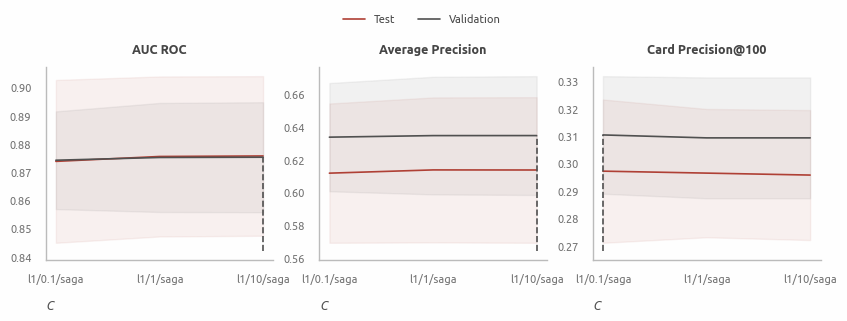

In [250]:
plot_performance(
    data=performance_lr_base_plot_estmators,
    metrics=metrics,
    subsets=subsets,
    xlabel='C',
    colors=[palette[1], palette[-1], palette[-1]],
    figsize=(10,2.5),
    save=True,
    filename='performance_lr'
)

##### Hyperparameters Dict

In [21]:
best_params_lr = summary_lr_base.loc['Best estimated parameters', 'Average Precision']

In [22]:
best_params_lr

'l2/1/saga'

In [23]:
hyper_lr_keys = hyper_dict['Logistic Regression'].keys()

In [24]:
hyper_lr_keys

dict_keys(['penalty', 'C', 'solver', 'max_iter', 'random_state'])

In [25]:
hyper_lr_params = best_params_lr.split('/')

In [26]:
hyper_lr_params[1] = ast.literal_eval(hyper_lr_params[1])

In [27]:
hyper_lr_params

['l2', 1, 'saga']

In [28]:
for key, param in zip(hyper_lr_keys, hyper_lr_params):
    hyper_dict['Logistic Regression'][key] = param

#### Random Forest

##### RF Baseline

In [29]:
clf_rf_base = RandomForestClassifier()

params_rf_base = {
    'estimator__n_estimators':[5, 10, 25, 50, 75, 100, 150],
    'estimator__max_depth':[10, 25, 50],
    'estimator__random_state':[seed]
}

preprop_rf_base = [
    ('scaler', StandardScaler())
]

grid_rf_base = grid_create(
    clf_rf_base, params_rf_base, preprop_rf_base,
    search_type='grid', key_params_idxs=[0,1]
)

In [30]:
t_perf = time.time()
performance_rf_base = model_performance_CV(data, **grid_rf_base)
exec_time_rf_base = time.time() - t_perf

In [31]:
exec_time_rf_base

1146.8715760707855

In [32]:
summary_rf_base = get_summary_performances(performance_rf_base, metrics)

In [33]:
summary_rf_base

,AUC ROC,Average Precision,Card Precision@100
Best estimated parameters,150/50,150/25,50/10
Validation performance,0.877+/-0.006,0.701+/-0.013,0.322+/-0.018
Test performance,0.876+/-0.021,0.678+/-0.029,0.301+/-0.017
Optimal parameter(s),150/50,150/25,50/25
Optimal test performance,0.876+/-0.021,0.678+/-0.029,0.306+/-0.020


In [34]:
estmators_esolate_lvl = '150'

performance_rf_base_plot_estmators = \
    performance_rf_base.loc[performance_rf_base['Parameters summary'] \
        .str.startswith(estmators_esolate_lvl)]

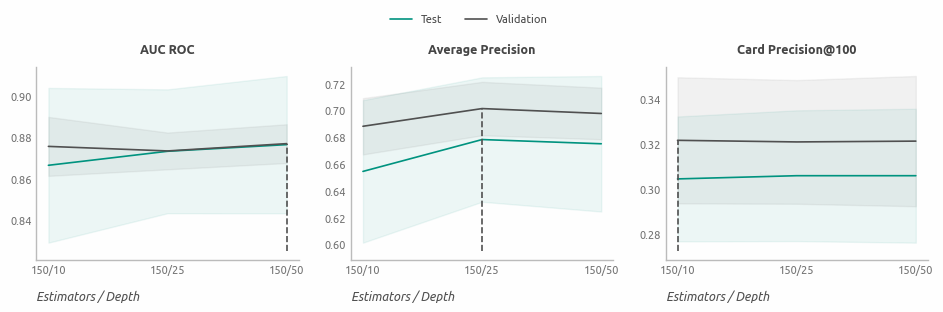

In [236]:
plot_performance(
    data=performance_rf_base_plot_estmators,
    metrics=metrics,
    subsets=subsets,
    xlabel='Estimators / Depth',
    colors=[palette[2], palette[-1], palette[-1]],
    figsize=(11.5,2.5),
)

In [36]:
depth_esolate_lvl = '25'

performance_rf_base_plot_depth = \
    performance_rf_base.loc[performance_rf_base['Parameters summary'] \
        .str.endswith(depth_esolate_lvl)]


Image 'performance_rf.png' successfully saved into 'img' directory


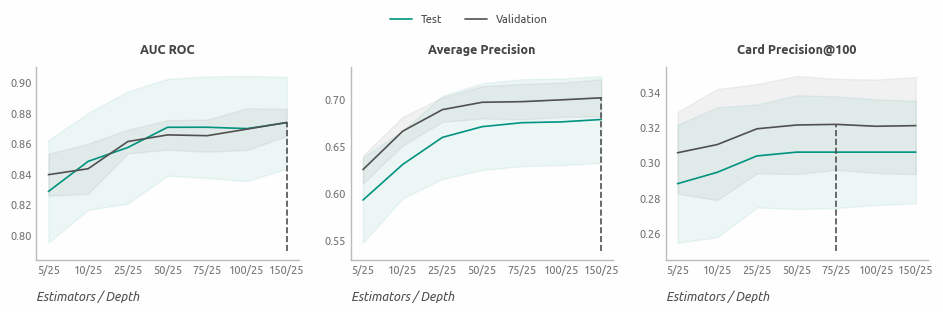

In [237]:
plot_performance(
    data=performance_rf_base_plot_depth,
    metrics=metrics,
    subsets=subsets,
    xlabel='Estimators / Depth',
    colors=[palette[2], palette[-1], palette[-1]],
    figsize=(11.5,2.5),
    # rotation=45,
    save=True,
    filename='performance_rf'
)

##### Hyperparameters Dict

In [38]:
best_params_rf = summary_rf_base.loc['Best estimated parameters', 'Average Precision']

In [39]:
best_params_rf

'150/25'

In [40]:
hyper_rf_keys = hyper_dict['Random Forest'].keys()

In [41]:
hyper_rf_params = [ast.literal_eval(i) for i in best_params_rf.split('/')]

In [42]:
for key, param in zip(hyper_rf_keys, hyper_rf_params):
    hyper_dict['Random Forest'][key] = param

#### XGBoost

##### XGB Baseline

In [43]:
clf_xgb_base = XGBClassifier()

params_xgb_base = {
    'estimator__n_estimators':[5, 10, 25, 50, 75, 100, 150],
    'estimator__max_depth':[3, 6, 9],
    'estimator__learning_rate':[0.1, 0.3],
    'estimator__random_state':[seed]
}

preprop_xgb_base = [
    ('scaler', StandardScaler())
]

grid_xgb_base = grid_create(
    clf_xgb_base, params_xgb_base, preprop_xgb_base,
    search_type='grid', key_params_idxs=[0,1,2]
)

In [44]:
t_perf = time.time()
performance_xgb_base = model_performance_CV(data, **grid_xgb_base)
exec_time_xgb_base = time.time() - t_perf

In [45]:
exec_time_xgb_base

2261.731897830963

In [46]:
summary_xgb_base = get_summary_performances(performance_xgb_base, metrics)

In [47]:
summary_xgb_base

,AUC ROC,Average Precision,Card Precision@100
Best estimated parameters,100/3/0.1,150/3/0.1,10/6/0.3
Validation performance,0.879+/-0.017,0.701+/-0.009,0.321+/-0.016
Test performance,0.875+/-0.016,0.692+/-0.031,0.302+/-0.018
Optimal parameter(s),75/3/0.3,150/3/0.1,100/3/0.1
Optimal test performance,0.877+/-0.011,0.692+/-0.031,0.308+/-0.018


In [48]:
estmators_esolate_lvl = '3/0.1'

performance_xgb_base_plot_estmators = \
    performance_xgb_base.loc[performance_xgb_base['Parameters summary'] \
        .str.endswith(estmators_esolate_lvl)]


Image 'performance_xgb.png' successfully saved into 'img' directory


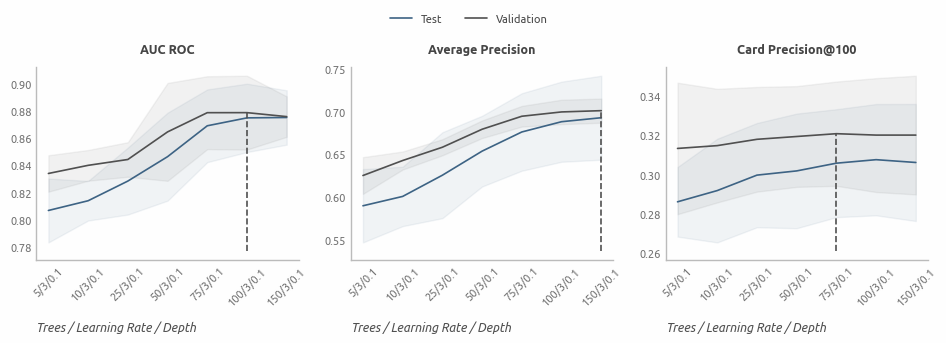

In [238]:
plot_performance(
    data=performance_xgb_base_plot_estmators,
    metrics=metrics,
    subsets=subsets,
    xlabel='Trees / Learning Rate / Depth',
    colors=[palette[-7], palette[-1], palette[-1]],
    figsize=(11.5,2.5),
    rotation=45,
    save=True,
    filename='performance_xgb'
)

In [50]:
depth_esolate_lvl = '150/3'

performance_xgb_base_plot_depth = \
    performance_xgb_base.loc[performance_xgb_base['Parameters summary'] \
        .str.startswith(depth_esolate_lvl)]

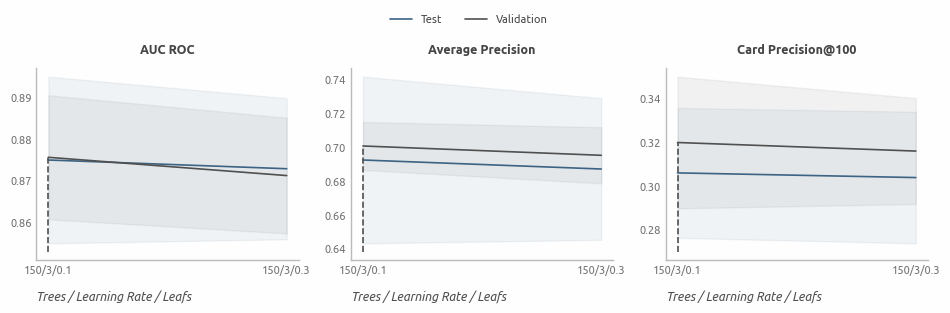

In [240]:
plot_performance(
    data=performance_xgb_base_plot_depth,
    metrics=metrics,
    subsets=subsets,
    xlabel='Trees / Learning Rate / Leafs',
    colors=[palette[-7], palette[-1], palette[-1]],
    rotation=0
)

##### Hyperparameters Dict

In [52]:
best_params_xgb = summary_xgb_base.loc['Best estimated parameters', 'Average Precision']

In [53]:
best_params_xgb

'150/3/0.1'

In [54]:
hyper_xgb_keys = hyper_dict['XGBoost'].keys()

In [55]:
hyper_xgb_params = [ast.literal_eval(i) for i in best_params_xgb.split('/')]

In [56]:
for key, param in zip(hyper_xgb_keys, hyper_xgb_params):
    hyper_dict['XGBoost'][key] = param

#### LightGBM

##### LGB Baseline

In [57]:
clf_lgb_base = LGBMClassifier()

params_lgb_base = {
    'estimator__n_estimators':[5, 10, 25, 50, 75, 100, 150],
    'estimator__max_depth':[3, 6, 9],
    'estimator__learning_rate':[0.1, 0.3],
    'estimator__random_state':[seed],
    'estimator__verbose': [-1]
}

preprop_lgb_base = [
    ('scaler', StandardScaler())
]

grid_lgb_base = grid_create(
    clf_lgb_base, params_lgb_base, preprop_lgb_base,
    search_type='grid', key_params_idxs=[0,1,2]
)

In [58]:
t_perf = time.time()
performance_lgb_base = model_performance_CV(data, **grid_lgb_base)
exec_time_lgb_base = time.time() - t_perf

In [59]:
exec_time_lgb_base

288.42339992523193

In [60]:
summary_lgb_base = get_summary_performances(performance_lgb_base, metrics)

In [61]:
summary_lgb_base

,AUC ROC,Average Precision,Card Precision@100
Best estimated parameters,150/3/0.1,150/3/0.1,150/3/0.1
Validation performance,0.865+/-0.013,0.654+/-0.021,0.321+/-0.015
Test performance,0.870+/-0.012,0.647+/-0.027,0.301+/-0.016
Optimal parameter(s),150/3/0.1,150/3/0.1,25/3/0.1
Optimal test performance,0.870+/-0.012,0.647+/-0.027,0.304+/-0.018


In [62]:
estmators_esolate_lvl = '150/3'

performance_lgb_base_plot_estmators = \
    performance_lgb_base.loc[performance_lgb_base['Parameters summary'] \
        .str.startswith(estmators_esolate_lvl)]

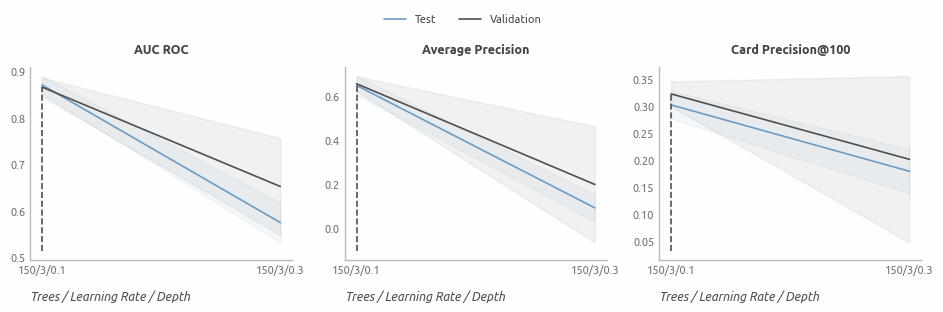

In [241]:
plot_performance(
    data=performance_lgb_base_plot_estmators,
    metrics=metrics,
    subsets=subsets,
    xlabel='Trees / Learning Rate / Depth',
    colors=[palette[-9], palette[-1], palette[-1]]
)

In [64]:
depth_esolate_lvl = '3/0.1'

performance_lgb_base_plot_depth = \
    performance_lgb_base.loc[performance_lgb_base['Parameters summary'] \
        .str.endswith(depth_esolate_lvl)]


Image 'performance_lgb.png' successfully saved into 'img' directory


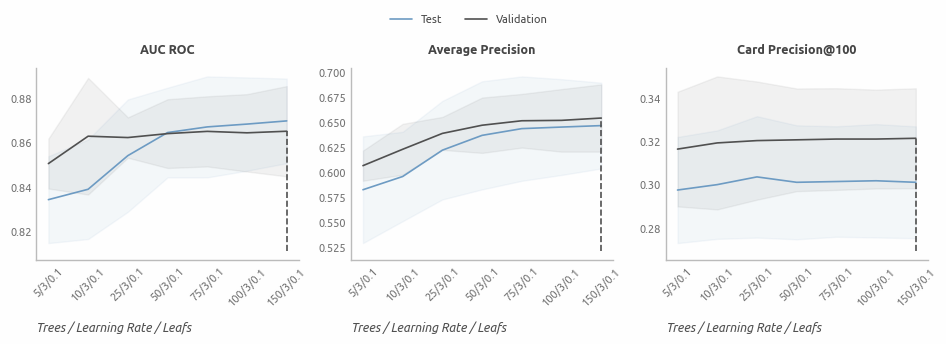

In [242]:
plot_performance(
    data=performance_lgb_base_plot_depth,
    metrics=metrics,
    subsets=subsets,
    xlabel='Trees / Learning Rate / Leafs',
    colors=[palette[-9], palette[-1], palette[-1]],
    rotation=45,
    save=True,
    filename='performance_lgb'
)

##### Hyperparameters Dict

In [66]:
best_params_lgb = summary_lgb_base.loc['Best estimated parameters', 'Average Precision']

In [67]:
best_params_lgb

'150/3/0.1'

In [68]:
hyper_lgb_keys = hyper_dict['LightGBM'].keys()

In [69]:
hyper_lgb_params = [ast.literal_eval(i) for i in best_params_lgb.split('/')]

In [70]:
for key, param in zip(hyper_lgb_keys, hyper_lgb_params):
    hyper_dict['LightGBM'][key] = param

### Save Results

In [71]:
performance_dict = {
    "Logistic Regression": performance_lr_base,
    "Random Forest": performance_rf_base,
    "XGBoost": performance_xgb_base,
    'LightGBM': performance_lgb_base
}

In [72]:
filehandler = open('_performance_base.pkl', 'wb') 
pickle.dump(performance_dict, filehandler)
filehandler.close()

In [73]:
summary_dict = {
    "Logistic Regression": summary_lr_base,
    "Random Forest": summary_rf_base,
    "XGBoost": summary_xgb_base,
    'LightGBM': summary_lgb_base
}

In [74]:
filehandler = open('_summary_base.pkl', 'wb') 
pickle.dump(summary_dict, filehandler)
filehandler.close()

In [75]:
hyper_dict

{'Logistic Regression': {'penalty': 'l2',
  'C': 1,
  'solver': 'saga',
  'max_iter': 5000,
  'random_state': 42},
 'Random Forest': {'n_estimators': 150, 'max_depth': 25, 'random_state': 42},
 'XGBoost': {'n_estimators': 150,
  'max_depth': 3,
  'learning_rate': 0.1,
  'random_state': 42},
 'LightGBM': {'n_estimators': 150,
  'max_depth': 3,
  'learning_rate': 0.1,
  'random_state': 42}}

In [76]:
filehandler = open('_hyperparameters_base.pkl', 'wb') 
pickle.dump(hyper_dict, filehandler)
filehandler.close()

In [77]:
time_exec_dict = {
    "Logistic Regression": exec_time_lr_base,
    "Random Forest": exec_time_rf_base,
    "XGBoost": exec_time_xgb_base,
    'LightGBM': exec_time_lgb_base
}

In [78]:
filehandler = open('_time_exec_base.pkl', 'wb') 
pickle.dump(time_exec_dict, filehandler)
filehandler.close()

### Save Session

In [79]:
save_session(dir_save)

### Executing time

In [80]:
e_time = str(dt.timedelta(seconds=np.round(time.time() - t_script)))
print('Execution time: {}'.format(e_time))

Execution time: 1:03:56
